In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d 'anujms/car-damage-detection'


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/anujms/car-damage-detection
License(s): unknown
  0% 0.00/123M [00:00<?, ?B/s]
100% 123M/123M [00:00<00:00, 1.71GB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('/content/car-damage-detection.zip','r') as zip_ref:
  zip_ref.extractall("/content/dataset_org")

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3,preprocess_input
import os

In [ ]:
DIRECTORY_TRAIN = '/content/dataset_org/data1a/training'
DIRECTORY_TEST = '/content/dataset_org/data1a/training'

train_df = []
test_df = []

for lable in os.listdir(DIRECTORY_TRAIN):
  path = os.path.join(DIRECTORY_TRAIN,lable)
  for img in os.listdir(path):
    filepath = os.path.join(path,img)
    lable = lable

    train_df.append([filepath,lable])


for lable in os.listdir(DIRECTORY_TEST):
  path = os.path.join(DIRECTORY_TEST,lable)
  for img in os.listdir(path):
    filepath = os.path.join(path,img)
    lable = lable

    test_df.append([filepath,lable])




In [ ]:
train_df = pd.DataFrame(train_df, columns=['filepath','label'])
test_df = pd.DataFrame(test_df, columns=['filepath','label'])

In [ ]:
train_df

,filepath,label
0,/content/dataset_org/data1a/training/00-damage...,00-damage
1,/content/dataset_org/data1a/training/00-damage...,00-damage
2,/content/dataset_org/data1a/training/00-damage...,00-damage
3,/content/dataset_org/data1a/training/00-damage...,00-damage
4,/content/dataset_org/data1a/training/00-damage...,00-damage
...,...,...
1835,/content/dataset_org/data1a/training/01-whole/...,01-whole
1836,/content/dataset_org/data1a/training/01-whole/...,01-whole
1837,/content/dataset_org/data1a/training/01-whole/...,01-whole
1838,/content/dataset_org/data1a/training/01-whole/...,01-whole


In [ ]:
train_df['label'] = train_df['label'].map({'01-whole':'whole', '00-damage':'damage'})
test_df['label'] = test_df['label'].map({'01-whole':'whole', '00-damage':'damage'})

In [ ]:
train_df

,filepath,label
0,/content/dataset_org/data1a/training/00-damage...,damage
1,/content/dataset_org/data1a/training/00-damage...,damage
2,/content/dataset_org/data1a/training/00-damage...,damage
3,/content/dataset_org/data1a/training/00-damage...,damage
4,/content/dataset_org/data1a/training/00-damage...,damage
...,...,...
1835,/content/dataset_org/data1a/training/01-whole/...,whole
1836,/content/dataset_org/data1a/training/01-whole/...,whole
1837,/content/dataset_org/data1a/training/01-whole/...,whole
1838,/content/dataset_org/data1a/training/01-whole/...,whole


In [ ]:
test_df

,filepath,label
0,/content/dataset_org/data1a/training/00-damage...,damage
1,/content/dataset_org/data1a/training/00-damage...,damage
2,/content/dataset_org/data1a/training/00-damage...,damage
3,/content/dataset_org/data1a/training/00-damage...,damage
4,/content/dataset_org/data1a/training/00-damage...,damage
...,...,...
1835,/content/dataset_org/data1a/training/01-whole/...,whole
1836,/content/dataset_org/data1a/training/01-whole/...,whole
1837,/content/dataset_org/data1a/training/01-whole/...,whole
1838,/content/dataset_org/data1a/training/01-whole/...,whole


In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 20,
    zoom_range = 0.15,
    horizontal_flip = True,
    height_shift_range = 0.2,
    width_shift_range = 0.2

    )

test_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input,
)

train_data = train_generator.flow_from_dataframe(
    train_df,
    x_col = 'filepath',
    y_col = 'label',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary',
    shuffle=True
)

test_data = test_generator.flow_from_dataframe(
    test_df,
    x_col = 'filepath',
    y_col = 'label',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary',
    shuffle=False
)

Found 1840 validated image filenames belonging to 2 classes.
Found 1840 validated image filenames belonging to 2 classes.


In [ ]:
from PIL import Image
import os

image_path = "/content/dataset_org/data1a/training/00-damage/0002.JPEG"
img = Image.open(image_path)

print("Width:", img.width)
print("Height:", img.height)
print("Size:", img.size)


Width: 275
Height: 183
Size: (275, 183)


In [ ]:
from tensorflow.keras.layers import Input,Dense,Dropout,GlobalAveragePooling2D, BatchNormalization,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

base_model = EfficientNetV2B3(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

base_model.trainable = False

inputs = Input(shape = (224,224,3))
x = base_model(inputs,training = False)
x = GlobalAveragePooling2D()(x)

x = Dense(128,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

# Final model
model = Model(inputs, outputs)

model.summary()


52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 7, 7, 1536)     │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,127,999 (50.08 MB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 12,930,878 (49.33 MB)

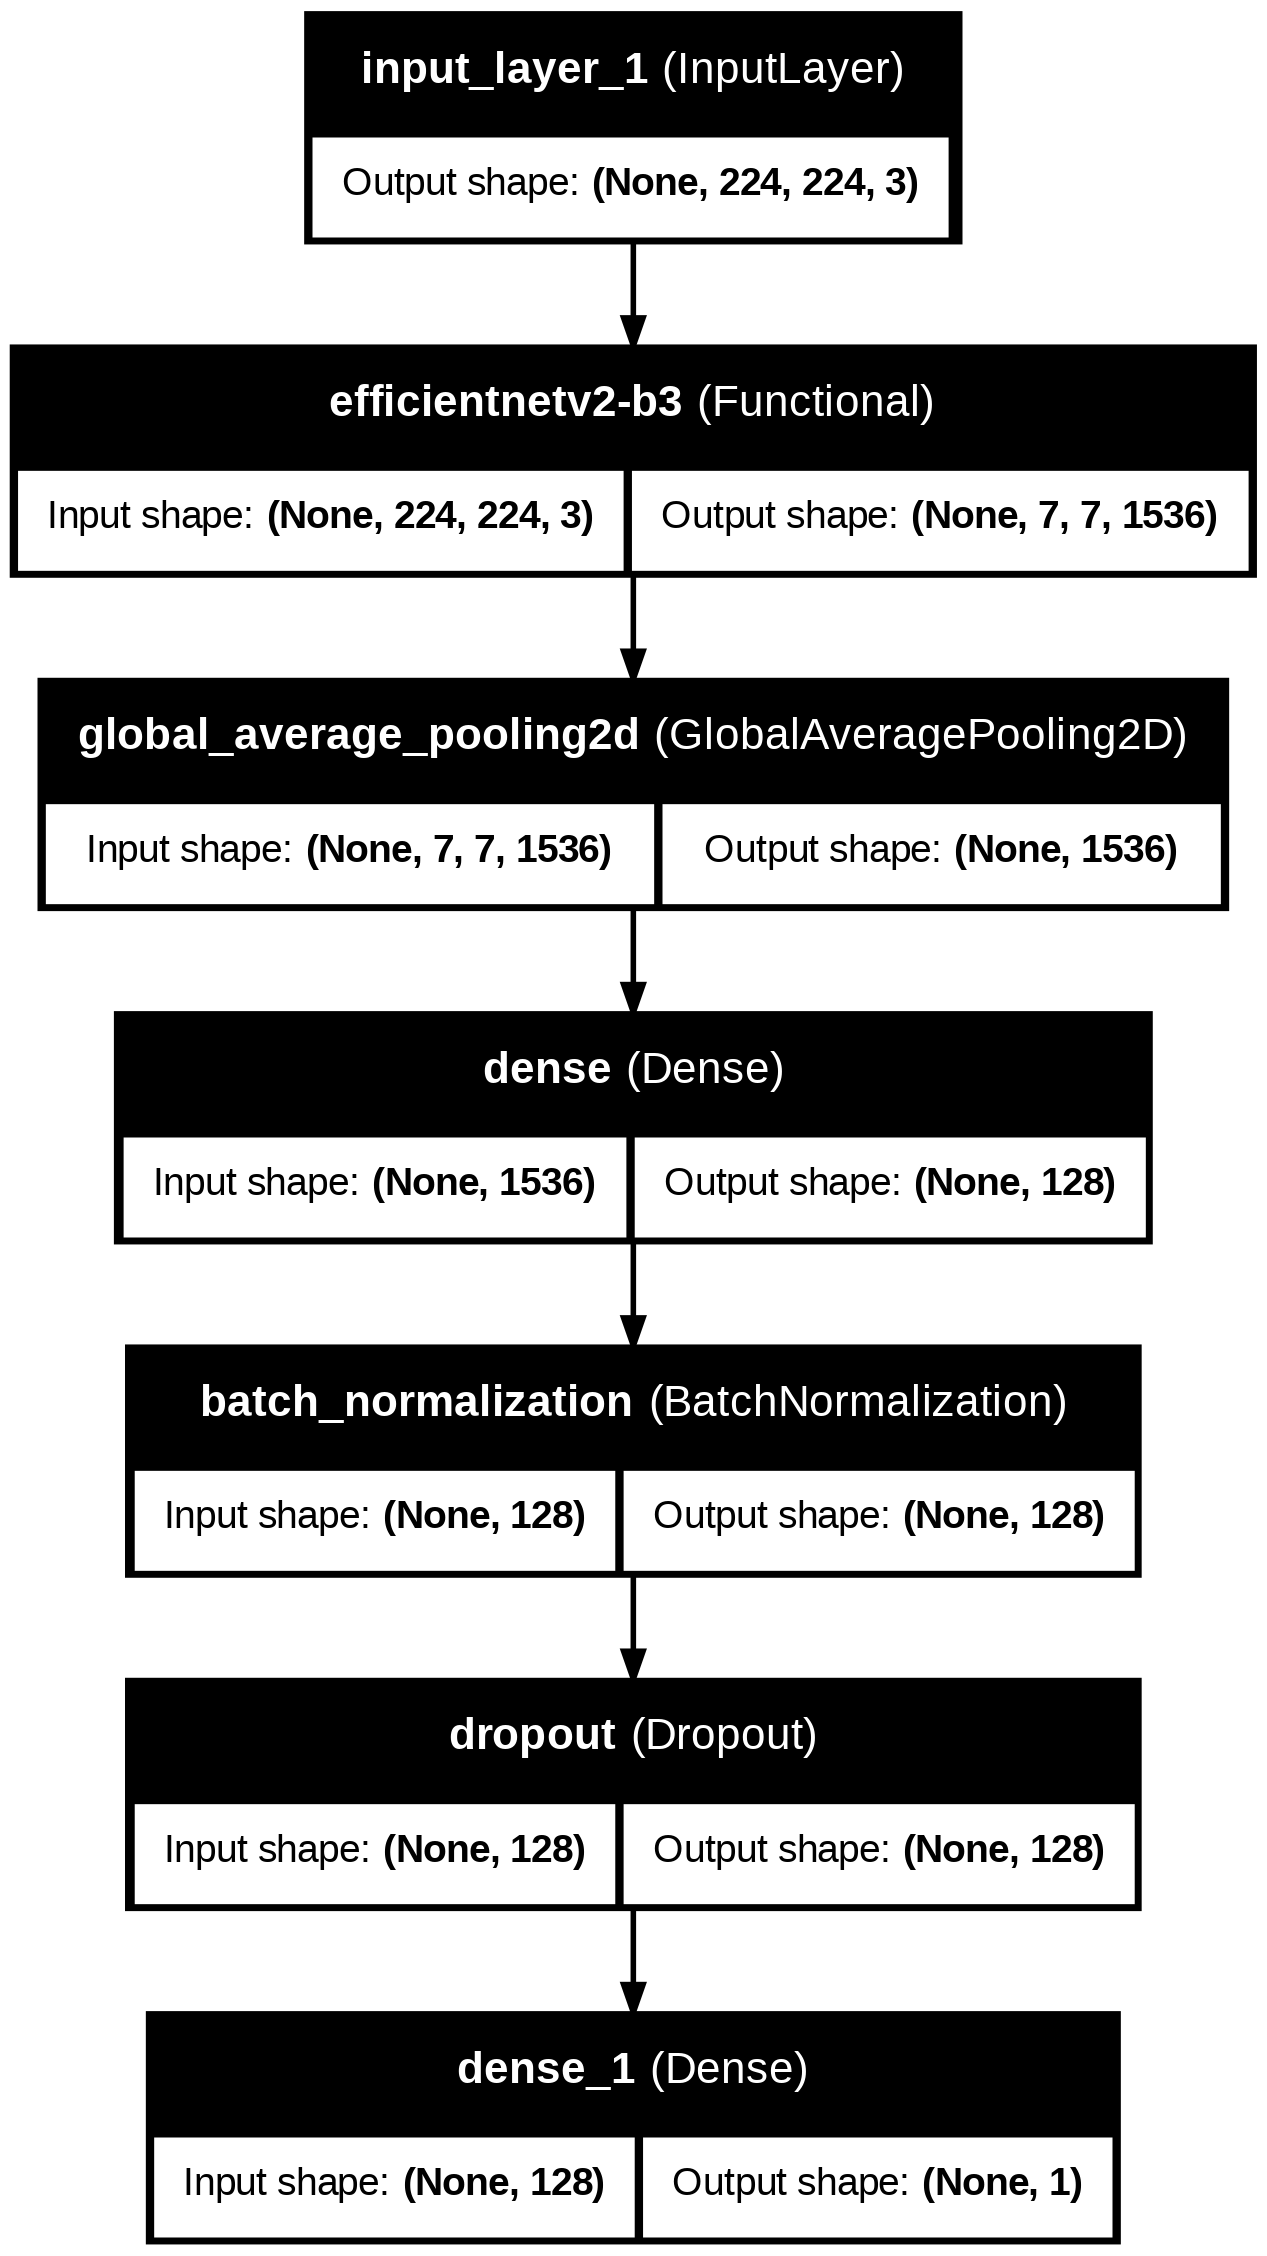

In [ ]:
plot_model(
    model,                     # your model
    show_shapes=True,          # display layer output shapes
    show_layer_names=True,     # display layer name
)


In [ ]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [ ]:
history = model.fit(train_data,epochs=10,validation_data=test_data,verbose=1)

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 498ms/step - accuracy: 0.9217 - loss: 0.2028 - val_accuracy: 0.9489 - val_loss: 0.1251
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 499ms/step - accuracy: 0.9106 - loss: 0.2030 - val_accuracy: 0.9511 - val_loss: 0.1166
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 496ms/step - accuracy: 0.9435 - loss: 0.1616 - val_accuracy: 0.9429 - val_loss: 0.1319
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 510ms/step - accuracy: 0.9175 - loss: 0.1983 - val_accuracy: 0.9565 - val_loss: 0.1086
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 492ms/step - accuracy: 0.9049 - loss: 0.2059 - val_accuracy: 0.9609 - val_loss: 0.1057
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 497ms/step - accuracy: 0.9402 - loss: 0.1665 - val_accuracy: 0.9620 - val_loss: 0.0992
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 506ms/step - accuracy: 0.9233 - loss: 0.1999 - val_accuracy: 0.9533 - val_loss: 0.1062
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 500ms/step - accuracy: 0.9245 - loss: 0.1904 - val_accu

In [ ]:
model.save('car_damage.keras')

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Path to a single test image
img_path = '/content/2721.jpg'

# Load image, resize to model input
img = image.load_img(img_path, target_size=(224, 224))

# Convert to array and expand dims (batch size = 1)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess for EfficientNetV2
img_array = preprocess_input(img_array)

# Make prediction
pred = model.predict(img_array)

# Interpret output (binary classification)
if pred[0][0] > 0.5:
    print("Predicted class: whole")
else:
    print("Predicted class: damage")

print("Raw prediction:", pred[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted class: damage
Raw prediction: 0.00072310644
